In [2]:
from random import randint
import numpy as np

In [3]:
def generate_sequence(length, n_features):
    return [randint(0, n_features - 1) for _ in range(length)]

In [4]:
def one_hot_encode(sequence, n_features):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_features)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

In [5]:
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

In [6]:
sequence = generate_sequence(25, 100)
print(sequence)

[16, 27, 65, 50, 84, 23, 9, 79, 23, 83, 55, 89, 38, 54, 56, 45, 33, 83, 73, 51, 63, 14, 87, 83, 90]


In [7]:
encoded = one_hot_encode(sequence, 100)
print(encoded)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
decoded = one_hot_decode(encoded)
print(decoded)

[16, 27, 65, 50, 84, 23, 9, 79, 23, 83, 55, 89, 38, 54, 56, 45, 33, 83, 73, 51, 63, 14, 87, 83, 90]


In [9]:
encoded.shape

(25, 100)

In [10]:
# samples, timesteps, features
X = encoded.reshape(1, 25, 100)
print(X.shape)

(1, 25, 100)


In [11]:
y = encoded[1, :]

In [12]:
y.shape

(100,)

In [14]:
def generate_example(length, n_features, out_index):
    sequence = generate_sequence(length, n_features)
    encoded = one_hot_encode(sequence, n_features)
    X = encoded.reshape((1, length, n_features))
    y = encoded[out_index].reshape(1, n_features)
    return X, y

In [15]:
X, y = generate_example(25, 100, 2)

In [16]:
X.shape, y.shape

((1, 25, 100), (1, 100))

In [17]:
X[0, 2] == y

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# 長さ5の系列を入れて2番目の要素を出力する
length = 5
n_features = 10
out_index = 2  # echo sequence predictionで入力の何番目の要素を返すか

In [20]:
model = Sequential()
model.add(LSTM(25, input_shape=(length, n_features)))
model.add(Dense(n_features, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                3600      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                260       
Total params: 3,860
Trainable params: 3,860
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
losses = []
accs = []
for i in range(10000):
    X, y = generate_example(length, n_features, out_index)
    history = model.fit(X, y, epochs=1, verbose=0)
    losses.append(history.history['loss'][0])
    accs.append(history.history['acc'][0])

In [72]:
len(losses), len(accs)

(10000, 10000)

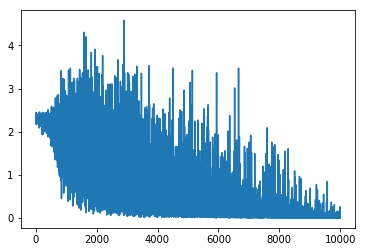

In [74]:
plt.plot(losses)

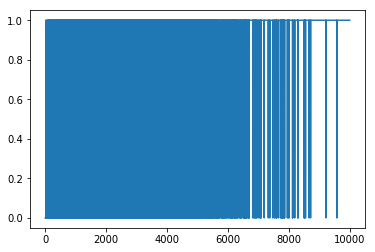

In [75]:
plt.plot(accs)

## PyTorch

In [22]:
from random import randint
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [42]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda available')
device = torch.device('cuda' if cuda else 'cpu')

In [158]:
def generate_sequence(length, n_features):
    return np.array([randint(0, n_features - 1) for _ in range(length)])

def one_hot_encode(sequence, n_features):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_features)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def generate_example(length, n_features, out_index):
    sequence = generate_sequence(length, n_features)
    encoded = one_hot_encode(sequence, n_features)
    
    # ndarray => tensor
    # PyTorchでは入力はfloatにする必要あり
    encoded = torch.from_numpy(encoded).float()
    
    # LSTMへの入力は3Dテンソル (seq_len, batch, input_size)
    X = encoded.view(length, 1, n_features)

    # out_index番目の入力を出力するようにする
    # PyTorchは出力はone-hotではなくラベルそのものを返す
    y = torch.Tensor([sequence[out_index]]).long()

    return X, y

In [159]:
generate_example(5, 10, 2)

(tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]],
 
         [[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]],
 
         [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]]]), tensor([ 2]))

In [170]:
# model
length = 5
n_features = 10
hidden_size = 25
out_index = 2

class EchoSequencePredictionModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, target_size):
        super(EchoSequencePredictionModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, target_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, h, c):
        output, (h, c) = self.lstm(input, (h, c))
        # 出力sequenceの一番最後のみ使う
        output = self.out(output)
        output = self.softmax(output)
        return output, (h, c)

    def init_hidden(self):
        # (num_layers * num_directions, batch, hidden_size)
        h = torch.zeros(1, 1, self.hidden_size).to(device)
        c = torch.zeros(1, 1, self.hidden_size).to(device)
        return h, c

In [171]:
model = EchoSequencePredictionModel(n_features, hidden_size, n_features).to(device)

In [172]:
model

EchoSequencePredictionModel(
  (lstm): LSTM(10, 25)
  (out): Linear(in_features=25, out_features=10, bias=True)
  (softmax): LogSoftmax()
)

In [173]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []

# training
for i in range(10000):
    # 系列データを1つ生成
    X, y = generate_example(length, n_features, out_index)

    # 系列を1つ入力してパラメータ更新したら勾配はリセット
    model.zero_grad()
    
    # 新しい系列を入力するたびに隠れ状態（hとc）はリセット
    # LSTMのパラメータは更新されたまま残る
    # TODO: self.hiddenとしてhiddenをモデル内部に埋め込む実装もある
    # https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
    h0, c0 = model.init_hidden()

    output, (h, c) = model(X, h0, c0)
    loss = criterion(output[-1], y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

In [174]:
len(losses)

10000

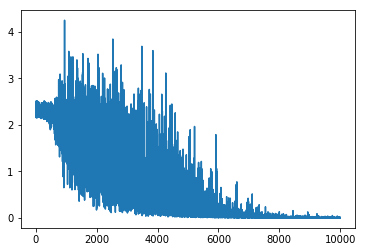

In [175]:
plt.plot(losses)